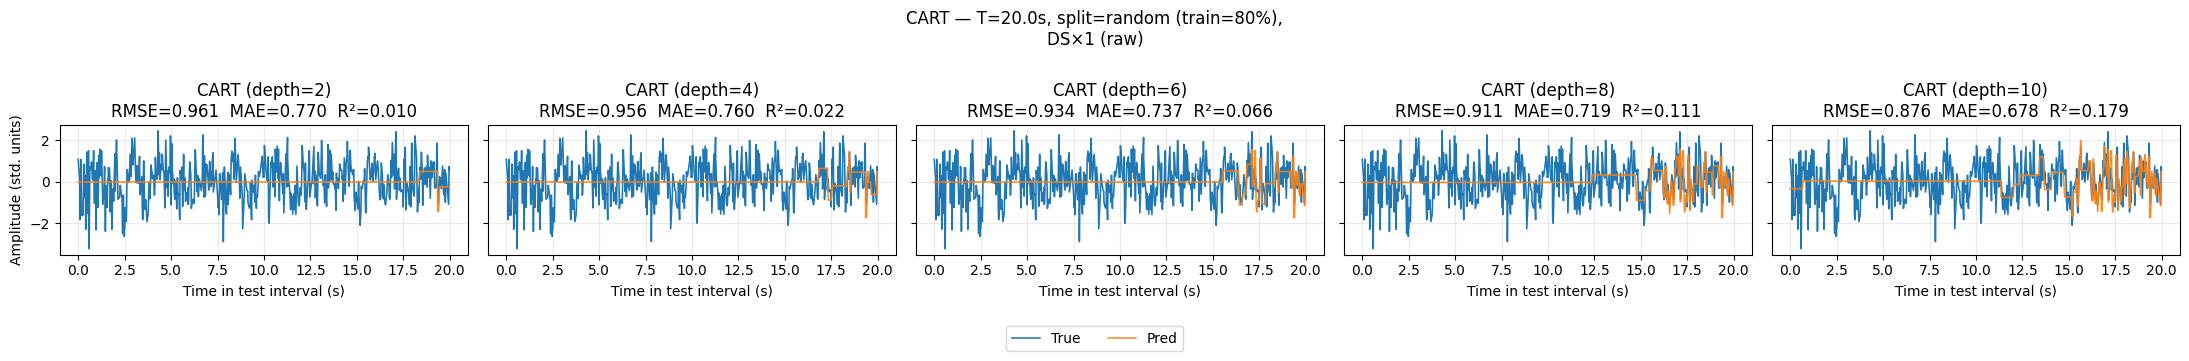

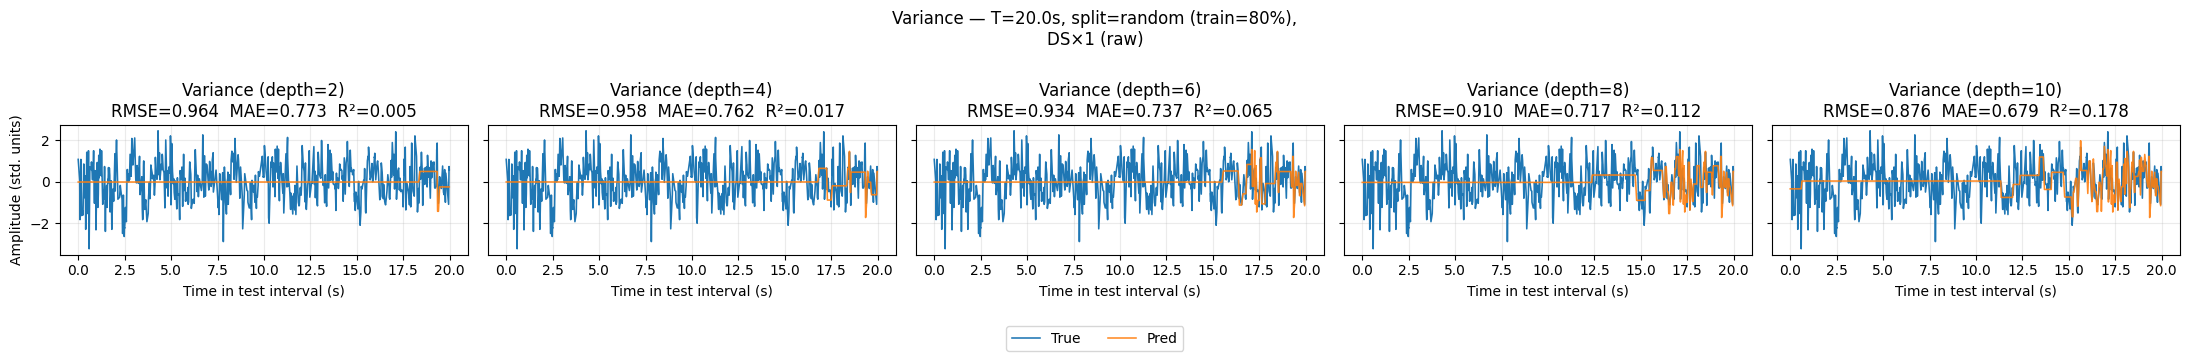

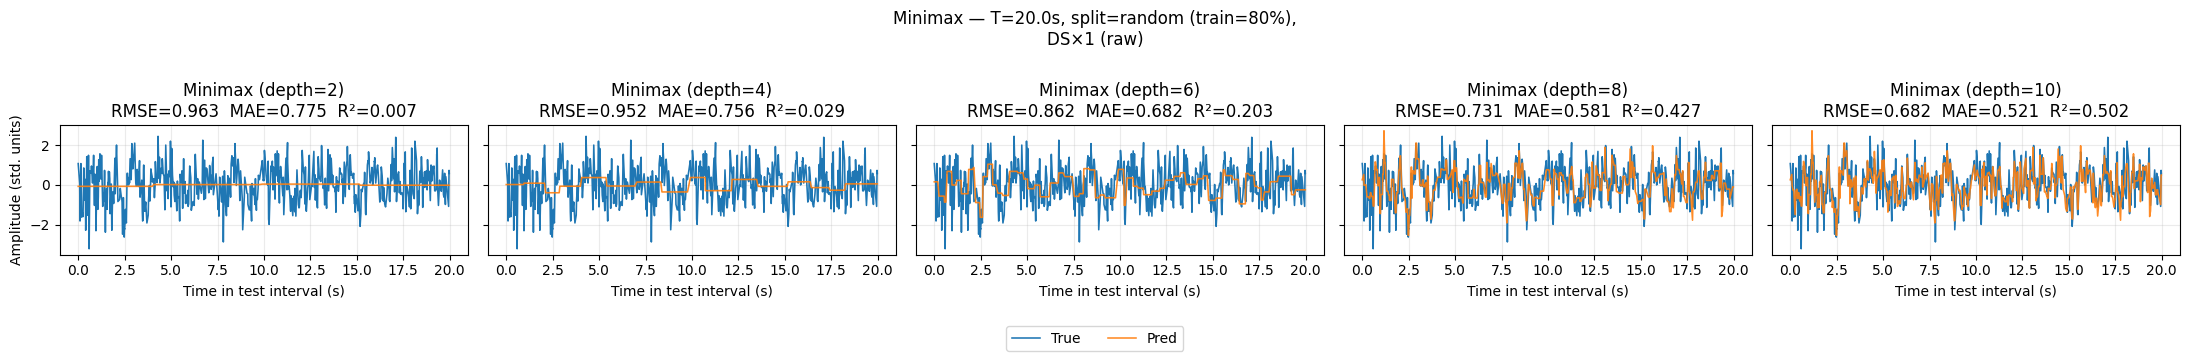


Saved CSVs:
- outputs/results_T20.0s_split-random_train80_ds1r_depths2-4-6-8-10_20250831-164931.csv
- outputs/summary_T20.0s_split-random_train80_ds1r_depths2-4-6-8-10_20250831-164931.csv

Per-segment pooled results (head):
  method  depth  seg_id group  n_train  n_test   RMSE    MAE     R2
    CART      2       0     Z     2777     695 0.9614 0.7701 0.0103
Variance      2       0     Z     2777     695 0.9639 0.7727 0.0050
 Minimax      2       0     Z     2777     695 0.9628 0.7755 0.0074
    CART      2       1     Z     2777     695 0.9541 0.7697 0.0266
Variance      2       1     Z     2777     695 0.9541 0.7697 0.0266

Summary (unweighted and weighted by n_test):
  method  depth  RMSE_mean  RMSE_std  MAE_mean  MAE_std  R2_mean  R2_std  wRMSE_mean  wRMSE_std  wMAE_mean  wMAE_std  wR2_mean  wR2_std  n_segments  n_test_total
    CART      2     0.9856    0.0311    0.7728   0.0413   0.0300  0.0339      0.9856     0.0310     0.7728    0.0412    0.0300   0.0338         500        3475

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
class DecisionTreeRegressor:
    def __init__(
        self,
        min_samples_split=2,
        max_depth=float('inf'),
        error_method='variance',
        cyclic_padding=0,
        loss_norm=2,
        *,
        use_decoupled_split=False,
        split_dim_criterion='variance',
        split_loc_criterion='variance',
        split_order='dimension_first'
    ):
        self.min_samples_split = min_samples_split
        self.max_depth = int(max_depth) if np.isfinite(max_depth) else float('inf')
        self.root = None
        self.cyclic_padding = cyclic_padding
        self.loss_norm = loss_norm
        # we only use legacy path with 'variance' or 'minimax' here
        if isinstance(error_method, list):
            self.error_method = error_method
        else:
            self.error_method = [error_method] * (self.max_depth if np.isfinite(self.max_depth) else 1)
        self.use_decoupled_split = False  # legacy path for this regression comparison

    class Node:
        def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None, data=None, targets=None, is_leaf=None):
            self.feature_index = feature_index
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value
            self.data = data
            self.targets = targets
            if self.left is None and self.right is None:
                self.is_leaf = True
            else:
                self.is_leaf = False

    def fit(self, X, y, depth=0):
        if len(X) < self.min_samples_split or depth >= self.max_depth:
            node = self.Node(value=float(np.mean(y)), data=X, targets=y)
            node.is_leaf = True
            if depth == 0: self.root = node
            return node
        idx = depth if depth < len(self.error_method) else 0
        current_error_method = self.error_method[idx]
        best_feature, best_threshold = self.find_best_split_legacy(X, y, current_error_method)
        if best_feature is None or best_threshold is None:
            node = self.Node(value=float(np.mean(y)), data=X, targets=y); node.is_leaf = True
            if depth == 0: self.root = node
            return node
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = ~left_indices
        left_subtree = self.fit(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self.fit(X[right_indices], y[right_indices], depth + 1)
        node = self.Node(feature_index=best_feature, threshold=best_threshold, left=left_subtree, right=right_subtree, data=X, targets=y)
        if depth == 0: self.root = node
        return node

    def find_best_split_legacy(self, X, y, error_method):
        num_features = X.shape[1]
        min_error = float('inf')
        best_feature = None
        best_threshold = None
        for feature_index in range(num_features):
            _, threshold, error = self.evaluate_splits(X, y, feature_index, error_method)
            if error < min_error:
                min_error = error
                best_feature = feature_index
                best_threshold = threshold
        return best_feature, best_threshold

    def evaluate_splits(self, X, y, feature_index, error_method):
        thresholds = np.unique(X[:, feature_index])
        min_error = float('inf')
        best_threshold = None
        for threshold in thresholds:
            left_indices = X[:, feature_index] <= threshold
            right_indices = ~left_indices
            error = self.calculate_error(y, left_indices, right_indices, error_method)
            if error < min_error:
                min_error = error
                best_threshold = threshold
        return feature_index, best_threshold, min_error

    def calculate_p_norm_error(self, y, indices, p):
        if p == np.inf:
            return np.max(np.abs(y[indices] - np.mean(y[indices])))
        else:
            return np.sum(np.abs(y[indices] - np.mean(y[indices])) ** p)

    def calculate_error(self, y, left_indices, right_indices, error_method):
        if np.sum(left_indices) <= 1 or np.sum(right_indices) <= 1:
            return np.inf
        if error_method in ('variance', 'minimax'):
            if self.loss_norm == 2:
                left_error = float(((y[left_indices] - np.mean(y[left_indices])) ** 2).sum())
                right_error = float(((y[right_indices] - np.mean(y[right_indices])) ** 2).sum())
            else:
                left_error = self.calculate_p_norm_error(y, left_indices, self.loss_norm)
                right_error = self.calculate_p_norm_error(y, right_indices, self.loss_norm)
            if error_method == 'minimax':
                return max(left_error, right_error)
            else:
                return left_error + right_error
        return np.inf

    def predict(self, X):
        return [self._predict_one(x, self.root) for x in X]

    def _predict_one(self, x, node):
        while not node.is_leaf:
            if x[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value
 
def rel_errors(pred, true):
    pred = np.asarray(pred, float)
    true = np.asarray(true, float)
    denom = np.maximum(np.abs(pred), np.abs(true))
    rel = np.where(true != 0.0, np.abs(pred - true) / denom, np.abs(pred))
    return rel

 
 


"""
Fixed-horizon EEG amplitude regression with trees (CART vs Variance vs Minimax)
-------------------------------------------------------------------------------
- Input: time t only within a fixed horizon T (no history/future features).
- Split modes:
    * "temporal": train first TRAIN_FRAC of [0,T], test the rest.
    * "random":   random TRAIN_FRAC split inside [0,T].
- If TRAIN_FRAC >= 1.0: training == testing (identical samples).
- For consistency: we PRECOMPUTE one split per segment and reuse it for all
  methods and depths. Results and plots are computed on exactly those splits.
"""

from pathlib import Path
import zipfile
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor as SklearnCART
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---- If your DecisionTreeRegressor isn't defined in this file, import it here.
# from your_module import DecisionTreeRegressor
MyTree = DecisionTreeRegressor  # alias to your provided class

# ======================
# Config
# ======================
FS_ORIG = 173.61  # Hz (Bonn)
PATHS = {
    "Z": "Z.zip",
    "O": "O.zip",
    "N": "N.zip",
    "F": "F.zip",
    "S": "S.zip",
}

FIXED_HORIZON_S = 20.0      # use first T seconds of each segment
TRAIN_FRAC      = 0.80      # if >= 1.0 → train==test (same samples)
SPLIT_MODE      = "random"  # {"temporal","random"}

DS_FACTOR = 1              # 1 = no downsampling
DS_METHOD = "raw"           # {"raw","poly"}; "raw" is fastest

DEPTHS = [2, 4, 6, 8, 10]
MIN_SAMPLES_SPLIT = 10
RANDOM_STATE = 42

# CSV output
OUTDIR = Path("outputs")
SAVE_CSV = True

# ======================
# I/O helpers
# ======================
def _parse_signal_bytes(b: bytes) -> np.ndarray:
    s = b.decode("latin1", errors="ignore")
    arr = np.fromstring(s, sep=" ")
    if arr.size < 100:
        arr = np.fromstring(s, sep="\n")
    return arr.astype(float)

def load_bonn_zip(zip_path: str) -> list[np.ndarray]:
    if not Path(zip_path).exists():
        raise FileNotFoundError(zip_path)
    segs = []
    with zipfile.ZipFile(zip_path, "r") as zf:
        for name in zf.namelist():
            if name.endswith("/"):
                continue
            with zf.open(name) as f:
                x = _parse_signal_bytes(f.read())
                if x.size > 0 and np.isfinite(x).all():
                    segs.append(x)
    return segs

def load_all_sets(paths: dict[str, str]) -> tuple[list[np.ndarray], list[str]]:
    signals, groups = [], []
    for set_name, zpath in paths.items():
        for x in load_bonn_zip(zpath):
            signals.append(x)
            groups.append(set_name)
    return signals, groups

# ======================
# Downsampling
# ======================
def _resample_poly_fallback(x: np.ndarray, up: int, down: int) -> np.ndarray:
    n_out = int(np.ceil(len(x) * up / down))
    xp = np.linspace(0.0, 1.0, len(x))
    fp = x.astype(float)
    xnew = np.linspace(0.0, 1.0, n_out)
    return np.interp(xnew, xp, fp)

try:
    from scipy.signal import resample_poly
except Exception:
    resample_poly = None

def downsample(x: np.ndarray, factor: int, method: str = "raw") -> np.ndarray:
    if factor is None or factor <= 1:
        return x.astype(float)
    x = x.astype(float)
    if method == "raw":
        return x[::factor].copy()
    elif method == "poly":
        if resample_poly is not None:
            return resample_poly(x, up=1, down=factor)
        return _resample_poly_fallback(x, up=1, down=factor)
    else:
        raise ValueError("DS_METHOD must be 'raw' or 'poly'")

# ======================
# Build per-segment fixed-horizon design (time → amplitude)
# ======================
def fixed_horizon_pairs(x_raw: np.ndarray, fs_orig: float, T_sec: float,
                        ds_factor: int, ds_method: str, standardize=True):
    fs_eff = fs_orig / max(1, ds_factor)
    n_keep = int(round(T_sec * fs_eff))
    x = downsample(x_raw, ds_factor, method=ds_method)
    if x.size < n_keep:
        return None  # too short
    x = x[:n_keep].astype(float)

    if standardize:
        mu, sd = float(x.mean()), float(x.std())
        x = (x - mu) / (sd if sd > 1e-8 else 1.0)

    t = np.arange(n_keep, dtype=float) / fs_eff        # seconds
    t_rel = t / t[-1]                                  # [0,1]
    X = t_rel.reshape(-1, 1)
    y = x.astype(float)
    return X, y, fs_eff

# ======================
# Metrics
# ======================
def rmse(a, b): return float(np.sqrt(mean_squared_error(a, b)))
def mae(a, b):  return float(mean_absolute_error(a, b))

# ======================
# Splitting helper
# ======================
def make_train_test(X, y, mode: str, train_frac: float, random_state: int):
    """
    Returns Xtr, Xte, ytr, yte.
    If train_frac >= 1.0, training and testing sets are identical (X, y).
    """
    if train_frac >= 1.0:
        return X, X, y, y

    if mode == "temporal":
        n = len(y)
        k = max(1, min(n - 1, int(round(train_frac * n))))
        return X[:k], X[k:], y[:k], y[k:]
    elif mode == "random":
        Xtr, Xte, ytr, yte = train_test_split(
            X, y, train_size=train_frac, random_state=random_state, shuffle=True
        )
        return Xtr, Xte, ytr, yte
    else:
        raise ValueError("SPLIT_MODE must be 'temporal' or 'random'")

# ======================
# Main experiment
# ======================
def run_fixed_horizon_experiment():
    # Load all signals & labels
    signals, groups = load_all_sets(PATHS)

    # Build per-segment designs (time → amplitude)
    segments = []
    for i, x_raw in enumerate(signals):
        out = fixed_horizon_pairs(x_raw, FS_ORIG, FIXED_HORIZON_S, DS_FACTOR, DS_METHOD, standardize=True)
        if out is None:
            continue
        X, y, _ = out
        g = groups[i] if i < len(groups) else "?"
        # Precompute a single split per segment
        Xtr, Xte, ytr, yte = make_train_test(X, y, SPLIT_MODE, TRAIN_FRAC, RANDOM_STATE)
        seg = dict(
            seg_id=i, group=g, X=X, y=y,
            Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte,
            n_train=len(ytr), n_test=len(yte)
        )
        segments.append(seg)

    if not segments:
        raise RuntimeError("No segments long enough for the chosen horizon.")

    # ============== Results (one row per segment × method × depth) ==============
    rows = []
    for depth in DEPTHS:
        for seg in segments:
            Xtr, Xte, ytr, yte = seg["Xtr"], seg["Xte"], seg["ytr"], seg["yte"]

            # (1) CART
            cart = SklearnCART(
                criterion="squared_error",
                max_depth=depth,
                min_samples_split=MIN_SAMPLES_SPLIT,
                random_state=RANDOM_STATE
            )
            cart.fit(Xtr, ytr)
            pred = cart.predict(Xte)
            rows.append({
                "method": "CART", "depth": depth,
                "seg_id": seg["seg_id"], "group": seg["group"],
                "n_train": seg["n_train"], "n_test": seg["n_test"],
                "RMSE": rmse(yte, pred), "MAE": mae(yte, pred), "R2": float(r2_score(yte, pred))
            })

            # (2) Variance
            var_tree = MyTree(min_samples_split=MIN_SAMPLES_SPLIT, max_depth=depth,
                              error_method="variance", loss_norm=2)
            var_tree.root = var_tree.fit(Xtr, ytr)
            pred = np.asarray(var_tree.predict(Xte), float)
            rows.append({
                "method": "Variance", "depth": depth,
                "seg_id": seg["seg_id"], "group": seg["group"],
                "n_train": seg["n_train"], "n_test": seg["n_test"],
                "RMSE": rmse(yte, pred), "MAE": mae(yte, pred), "R2": float(r2_score(yte, pred))
            })

            # (3) Minimax
            mm_tree = MyTree(min_samples_split=MIN_SAMPLES_SPLIT, max_depth=depth,
                             error_method="minimax", loss_norm=2)
            mm_tree.root = mm_tree.fit(Xtr, ytr)
            pred = np.asarray(mm_tree.predict(Xte), float)
            rows.append({
                "method": "Minimax", "depth": depth,
                "seg_id": seg["seg_id"], "group": seg["group"],
                "n_train": seg["n_train"], "n_test": seg["n_test"],
                "RMSE": rmse(yte, pred), "MAE": mae(yte, pred), "R2": float(r2_score(yte, pred))
            })

    results = pd.DataFrame(rows)

    # ============== Summary (unweighted AND test-size–weighted) ==============
    def _wavg(s, w):  # weighted average
        s = np.asarray(s, float); w = np.asarray(w, float)
        m = np.average(s, weights=w) if np.sum(w) > 0 else np.nan
        return float(m)

    def _wstd(s, w):  # weighted std (unbiased-ish)
        s = np.asarray(s, float); w = np.asarray(w, float)
        if np.sum(w) <= 0:
            return np.nan
        m = np.average(s, weights=w)
        v = np.average((s - m) ** 2, weights=w)
        return float(np.sqrt(v))

    groups_summary = []
    for (method, depth), gdf in results.groupby(["method", "depth"]):
        # Unweighted
        rmse_mu = gdf["RMSE"].mean(); rmse_sd = gdf["RMSE"].std()
        mae_mu  = gdf["MAE"].mean();  mae_sd  = gdf["MAE"].std()
        r2_mu   = gdf["R2"].mean();   r2_sd   = gdf["R2"].std()
        # Weighted by number of test points
        w = gdf["n_test"].clip(lower=1)
        wrmse_mu = _wavg(gdf["RMSE"], w); wrmse_sd = _wstd(gdf["RMSE"], w)
        wmae_mu  = _wavg(gdf["MAE"],  w); wmae_sd  = _wstd(gdf["MAE"],  w)
        wr2_mu   = _wavg(gdf["R2"],   w); wr2_sd   = _wstd(gdf["R2"],   w)

        groups_summary.append({
            "method": method, "depth": depth,
            "RMSE_mean": rmse_mu, "RMSE_std": rmse_sd,
            "MAE_mean":  mae_mu,  "MAE_std":  mae_sd,
            "R2_mean":   r2_mu,   "R2_std":   r2_sd,
            "wRMSE_mean": wrmse_mu, "wRMSE_std": wrmse_sd,
            "wMAE_mean":  wmae_mu,  "wMAE_std":  wmae_sd,
            "wR2_mean":   wr2_mu,   "wR2_std":   wr2_sd,
            "n_segments": int(len(gdf)), "n_test_total": int(gdf["n_test"].sum())
        })

    summary = pd.DataFrame(groups_summary).sort_values(["method", "depth"]).reset_index(drop=True)

    # ============== Plots (on ONE representative segment, same split as results) ==============
    rep = segments[0]
    # Time axis for test points in seconds
    if TRAIN_FRAC >= 1.0:
        # identical train/test; sort for readability
        order = np.argsort(rep["Xte"].ravel())
        Xte_plot = rep["Xte"][order]
        yte_plot = rep["yte"][order]
        te_time = Xte_plot.ravel() * FIXED_HORIZON_S
    elif SPLIT_MODE == "temporal":
        Xte_plot = rep["Xte"]; yte_plot = rep["yte"]
        te_time = (Xte_plot.ravel() - Xte_plot.ravel()[0]) * FIXED_HORIZON_S
    else:
        Xte_plot = rep["Xte"]; yte_plot = rep["yte"]
        te_time = Xte_plot.ravel() * FIXED_HORIZON_S

    for method in ("CART", "Variance", "Minimax"):
        fig, axes = plt.subplots(1, len(DEPTHS), figsize=(4.4 * len(DEPTHS), 3.0), sharey=True)
        if len(DEPTHS) == 1:
            axes = [axes]
        for j, depth in enumerate(DEPTHS):
            # train on the SAME split as in results
            Xtr, Xte, ytr, yte = rep["Xtr"], rep["Xte"], rep["ytr"], rep["yte"]

            if method == "CART":
                mdl = SklearnCART(criterion="squared_error", max_depth=depth,
                                  min_samples_split=MIN_SAMPLES_SPLIT, random_state=RANDOM_STATE)
                mdl.fit(Xtr, ytr)
                yhat = mdl.predict(Xte)
                # if plotting order was sorted, re-predict on sorted Xte_plot for a clean line
                if TRAIN_FRAC >= 1.0:
                    yhat_plot = mdl.predict(Xte_plot)
                else:
                    yhat_plot = yhat
            elif method == "Variance":
                mdl = MyTree(min_samples_split=MIN_SAMPLES_SPLIT, max_depth=depth,
                             error_method="variance", loss_norm=2)
                mdl.root = mdl.fit(Xtr, ytr)
                yhat = np.asarray(mdl.predict(Xte), float)
                yhat_plot = np.asarray(mdl.predict(Xte_plot), float) if TRAIN_FRAC >= 1.0 else yhat
            else:
                mdl = MyTree(min_samples_split=MIN_SAMPLES_SPLIT, max_depth=depth,
                             error_method="minimax", loss_norm=2)
                mdl.root = mdl.fit(Xtr, ytr)
                yhat = np.asarray(mdl.predict(Xte), float)
                yhat_plot = np.asarray(mdl.predict(Xte_plot), float) if TRAIN_FRAC >= 1.0 else yhat

            # metrics on the SAME (unsorted) test data used in results
            R = rmse(yte, yhat); M = mae(yte, yhat); R2 = float(r2_score(yte, yhat))

            ax = axes[j]
            #ax.scatter(te_time, yte_plot, label="True", linewidth=1.15)
            #ax.scatter(te_time, yhat_plot, label="Pred", linewidth=1.15, alpha=0.9)

            order = np.argsort(te_time)              # sort only for visualization
            t_draw   = te_time[order]
            ytrue_d  = yte_plot[order]
            ypred_d  = yhat_plot[order]

            ax.plot(t_draw, ytrue_d, label="True", lw=1.15)
            ax.plot(t_draw, ypred_d, label="Pred", lw=1.15, alpha=0.9)

            ax.set_title(f"{method} (depth={depth})\nRMSE={R:.3f}  MAE={M:.3f}  R²={R2:.3f}")
            ax.set_xlabel("Time in test interval (s)")
            if j == 0:
                ax.set_ylabel("Amplitude (std. units)")
            ax.grid(alpha=0.25)
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc="lower center", ncol=2, frameon=True, bbox_to_anchor=(0.5,-0.15))
        fig.suptitle(
            f"{method} — T={FIXED_HORIZON_S:.1f}s, split={SPLIT_MODE} (train={int(min(TRAIN_FRAC,1.0)*100)}%),\n"
            f"DS×{DS_FACTOR} ({DS_METHOD})",
            y=1.01
        )
        fig.tight_layout()
        plt.show()

    # ============== Save CSVs with parameterized filenames (optional) ==============
    if SAVE_CSV:
        OUTDIR.mkdir(parents=True, exist_ok=True)
        tag = (
            f"T{FIXED_HORIZON_S:.1f}s_split-{SPLIT_MODE}_train{int(min(TRAIN_FRAC,1.0)*100)}_"
            f"ds{DS_FACTOR}{DS_METHOD[0]}_depths{'-'.join(map(str, DEPTHS))}"
        )
        stamp = datetime.now().strftime("%Y%m%d-%H%M%S")

        results_meta = results.assign(
            ds_factor=DS_FACTOR, ds_method=DS_METHOD, fixed_horizon_s=FIXED_HORIZON_S,
            split_mode=SPLIT_MODE, train_frac=TRAIN_FRAC, fs_orig=FS_ORIG
        )
        summary_meta = summary.assign(
            ds_factor=DS_FACTOR, ds_method=DS_METHOD, fixed_horizon_s=FIXED_HORIZON_S,
            split_mode=SPLIT_MODE, train_frac=TRAIN_FRAC, fs_orig=FS_ORIG
        )

        res_path = OUTDIR / f"results_{tag}_{stamp}.csv"
        sum_path = OUTDIR / f"summary_{tag}_{stamp}.csv"
        results_meta.to_csv(res_path, index=False)
        summary_meta.to_csv(sum_path, index=False)
        print(f"\nSaved CSVs:\n- {res_path}\n- {sum_path}")

    # ============== Print tables
    print("\nPer-segment pooled results (head):")
    print(results.round(4).head().to_string(index=False))
    print("\nSummary (unweighted and weighted by n_test):")
    print(summary.round(4).to_string(index=False))

    return results, summary


if __name__ == "__main__":
    _res, _sum = run_fixed_horizon_experiment()


In [2]:
_res.to_csv('EEG_results.csv')
_sum.to_csv('EEG_summary.csv')
